In [1]:
# %load D:/BUDS_MID/__init__.py
"""
Created on Wed Feb 19 16:21:00 2020

@author: cmchico

usual imports
"""

import os
import pandas as pd
import numpy as np

pd.options.display.max_rows = 100
pd.set_option('display.float_format', '{:.0f}'.format)

from time import time
from datetime import timedelta

import pickle

import datetime as dt

In [2]:
# %load D:/BUDS_MID/__initdask__.py
"""
Created on Wed Feb 19 16:24:03 2020

@author: cmchico
"""
import dask.bag as db
from dask.distributed import Client, progress
from dask import delayed

client = Client(processes = True,n_workers=12)
client

Client Scheduler: tcp://127.0.0.1:49870 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 12 Cores: 12 Memory: 34.14 GB


In [3]:
out = 'D:/BUDS OUT/ATM Ticket/'

### Step 1: Combine all Tickets to 1

In [4]:
@delayed
def get_comms(path):
    df = pd.read_excel(path+'COMMS.xlsx',
                usecols=['Ticket Identifier TH',
                            'ATM ID TH',
                            'Object  Address Line 1 TH',
                            'Object City Name TH',
                            'Start Date - Local TH',
                            'End Date - Local TH',
                            'Start Time - Local TH',
                            'End Time - Local TH',
                            'Total Ticket Duration TH',
                             'TYPE'],
                dtype={'Start Date - Local TH':str,
                      'End Date - Local TH':str,
                      'Start Time - Local TH':str,
                      'End Time - Local TH':str}
                             ).assign(t_type='COMMS')
    
    df['Final Actual Arr Date - Local TH'] = None
    df['Final Actual Arr Time - Local TH'] = None
    
    df = df[df.TYPE == 'ATM'].copy()
    df.rename(columns={
    'ATM ID TH':'ATM',
    'Ticket Identifier TH':'t_no',
    'Object  Address Line 1 TH':'t_address',
    'Object City Name TH':'t_city',
    'Start Date - Local TH':'t_start_date',
    'End Date - Local TH':'t_end_date',
    'Start Time - Local TH':'t_start_time',
    'End Time - Local TH':'t_end_time',
    'Final Actual Arr Date - Local TH':'t_end_date2',
    'Final Actual Arr Time - Local TH':'t_end_time2',
    }, inplace=True)
    return df[['ATM'] + [col for col in df.columns if col[:2]=='t_' ]]

@delayed
def get_others(path,type_):
    
    usecols_ = ['Ticket #', 
                    'Object ID','ATM Name', 'Area','Start Date', 'Start Time',
                       'End Date', 'End Time','TYPE']
    
    dtype_ = {'Start Date':str,
                   'Start Time':str,
                  'End Date':str,
                  'End Time':str} 
    
    if type_ != 'OCCF':
        usecols_ = usecols_ + ['Final Actual Arr Date','Final Actual Arr Time']
        dtype_['Final Actual Arr Date'] = str
        dtype_['Final Actual Arr Time'] = str
    
    df = pd.read_excel(path+type_+'.xlsx',
            usecols=usecols_,
            dtype=dtype_).assign(t_type=type_)
    
    df = df[df.TYPE == 'ATM'].copy()
    df.rename(columns={
    'Object ID':'ATM',
    'Ticket #':'t_no',
    'ATM Name':'t_address',
    'Area':'t_city',
    'Start Date':'t_start_date',
    'End Date':'t_end_date',
    'Start Time':'t_start_time',
    'End Time':'t_end_time',
    }, inplace=True)
    
    if type_ != 'OCCF':
        df.rename(columns={'Final Actual Arr Date':'t_end_date2',
                'Final Actual Arr Time':'t_end_time2'}, inplace=True)
    else:
        df['t_end_date2'] = None
        df['t_end_time2'] = None
    
    return df

@delayed
def fix(df,year):
#     df['t_start_date'] = df['t_start_date'].ffill()
    df = df[~df.ATM.isnull()].copy()
    df['t_start'] = pd.to_datetime(df['t_start_date'].ffill())
    
    #replace missing end date and time with Final Actual Arr date and time columns
    df.t_end_date = df['t_end_date'].fillna(df.t_end_date2)
    df.t_end_time = df['t_end_time'].fillna(df.t_end_time2)
    
    df['t_end'] = pd.to_datetime(df['t_end_date'])
    
    select = df[['t_start_date','t_start_time']].isnull().sum(axis=1)==0
    df.loc[select,'t_start'] = pd.to_datetime(df.loc[select,'t_start_date'] + ' '+ df.loc[select,'t_start_time'])
    
    
    select = df[['t_end_date','t_end_time']].isnull().sum(axis=1)==0
    df.loc[select,'t_end'] = pd.to_datetime(df.loc[select,'t_end_date'] + ' '+ df.loc[select,'t_end_time'])
    
    #if missing end date, assume ticket unresolved, at least 1 day of unavailability
    select = df.t_end_date.isnull()
    df.loc[select,'t_end'] = df.loc[select,'t_start'] + timedelta(days=1)
    
    
    #sanitation check, if end_date < start_date, correct end_date must be the final actual...
    select = df.t_end < df.t_start
    df.loc[select,'t_end'] = pd.to_datetime(df.loc[select,'t_end_date'] + ' '+ df.loc[select,'t_end_time'])
    
    
    #if final actual is also < start date, then assume 1 day of unavailability
    select = df.t_end < df.t_start
    df.loc[select,'t_end'] = df.loc[select,'t_start'] + timedelta(days=1)
    
    df['tid'] = ('9101' +  df['ATM'].str[-4:]).astype(int)

    return df[['tid']+[col for col in df.columns if col[:2]=='t_' ]]

In [179]:
# start = time()
# year='2018'
# path = 'D:/BUDS/ATM Tickets/'+year+'/'+year+'/'
# comms = fix(get_comms(path),year).compute()
# flm = fix(get_others(path,'FLM'),year).compute()
# occf = fix(get_others(path,'OCCF'),year).compute()
# slm = fix(get_others(path,'SLM'),year).compute()
# df = pd.concat([occf,flm,slm,comms], ignore_index=True)
# print(timedelta(seconds=time()-start))

In [180]:
# slm[slm.t_no == 72015784]

In [181]:
def year_(year):
    path = 'D:/BUDS/ATM Tickets/'+year+'/'+year+'/'
    comms = fix(get_comms(path),year)
    flm = fix(get_others(path,'FLM'),year)
    occf = fix(get_others(path,'OCCF'),year)
    slm = fix(get_others(path,'SLM'),year)
    
    return [occf,comms,flm,slm]

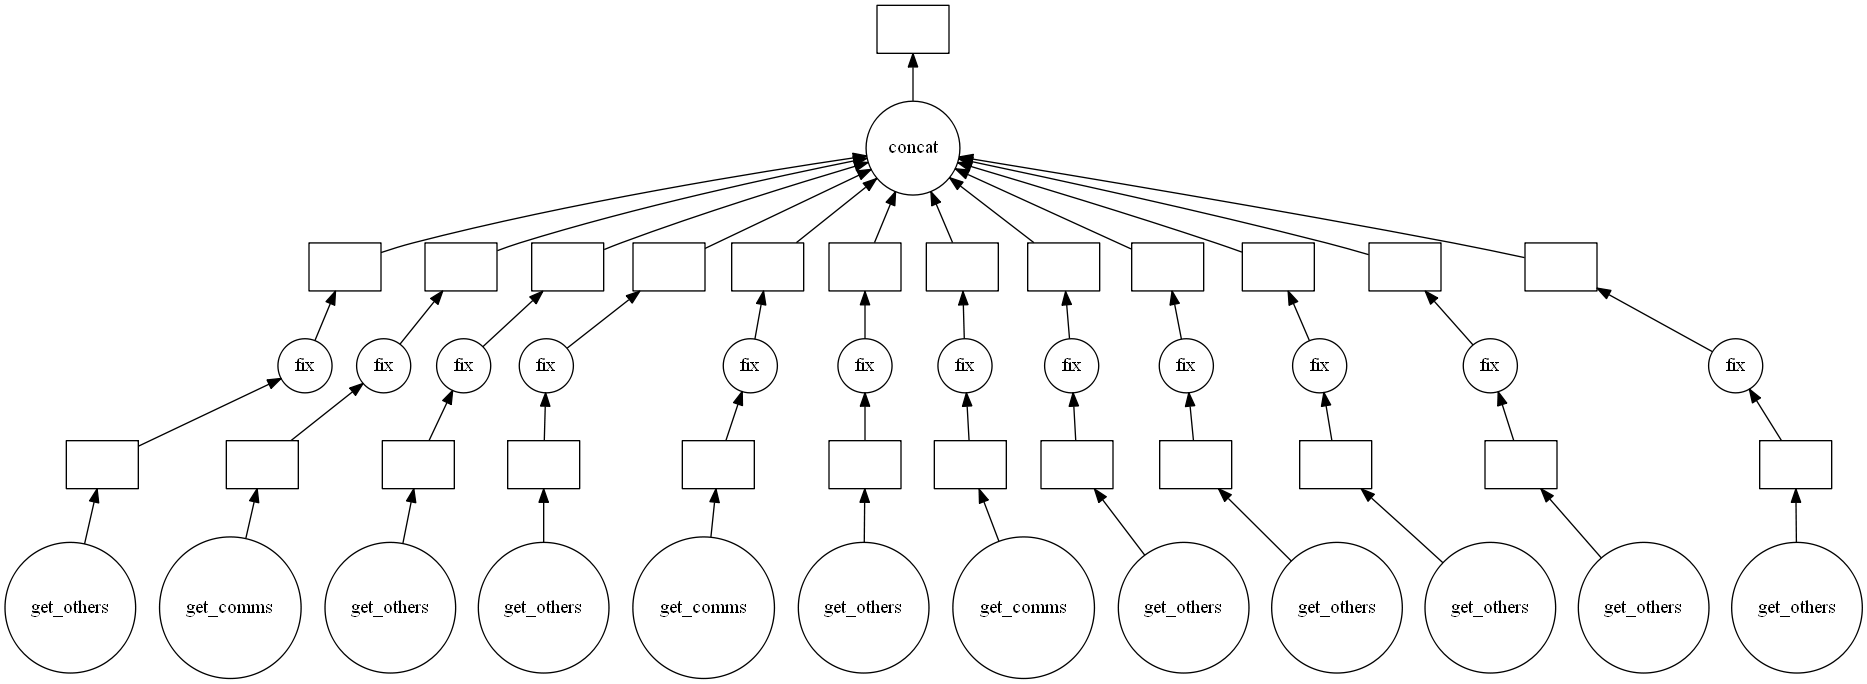

In [182]:
df = delayed(pd.concat)(year_('2017') + year_('2018') + year_('2019'), ignore_index=True)
df.visualize()

In [183]:
start = time()
fin = df.compute()
fin.sort_values(by=['tid','t_start'], ignore_index=True, inplace=True)
fin.to_pickle(out+'Ticket_All_Raw.pkl')
print(timedelta(seconds=time()-start))

0:05:17.046881


In [184]:
fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190494 entries, 0 to 1190493
Data columns (total 13 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   tid           1190494 non-null  int32         
 1   t_no          1190494 non-null  float64       
 2   t_address     1190494 non-null  object        
 3   t_city        1185445 non-null  object        
 4   t_start_date  1190456 non-null  object        
 5   t_start_time  1190456 non-null  object        
 6   t_end_date    1177552 non-null  object        
 7   t_end_time    1177552 non-null  object        
 8   t_type        1190494 non-null  object        
 9   t_end_date2   312066 non-null   object        
 10  t_end_time2   312066 non-null   object        
 11  t_start       1190494 non-null  datetime64[ns]
 12  t_end         1190494 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int32(1), object(9)
memory usage: 113.5+ MB


In [21]:
fin.sort_values(by=['tid','t_start'], ignore_index=True, inplace=True)
fin.to_pickle(out+'80 Ticket_All_Raw.pkl')

In [22]:
fin[fin.t_start > fin.t_end]

,tid,t_no,t_address,t_city,t_start_date,t_start_time,t_end_date,t_end_time,t_type,t_end_date2,t_end_time2,t_start,t_end,t_start_2,t_end_2,t_merge


In [25]:
fin[fin.t_start >= fin.t_end]

,tid,t_no,t_address,t_city,t_start_date,t_start_time,t_end_date,t_end_time,t_type,t_end_date2,t_end_time2,t_start,t_end,t_start_2,t_end_2,t_merge
105,91010003,56779383,MATINA TOWN SQUARE,Davao City,2017-10-22 00:00:00,16:18:00,2017-10-22 00:00:00,16:18:00,SLM,NaN,NaN,2017-10-22 16:18:00,2017-10-22 16:18:00,2017-10-22 16:18:00,2017-10-22 16:18:00,
117,91010003,58931104,MATINA TOWN SQUARE,Davao City,2017-12-15 00:00:00,14:41:00,2017-12-15 00:00:00,14:41:00,SLM,2017-12-15 00:00:00,14:41:00,2017-12-15 14:41:00,2017-12-15 14:41:00,2017-12-15 14:41:00,2017-12-15 14:41:00,
120,91010003,59782371,MATINA TOWN SQUARE,Davao City,2018-01-20 00:00:00,16:19:00,2018-01-20 00:00:00,16:19:00,FLM,2018-01-20 00:00:00,16:19:00,2018-01-20 16:19:00,2018-01-20 16:19:00,2018-01-20 16:19:00,2018-01-20 16:19:00,
121,91010003,59782371,MATINA TOWN SQUARE,Davao City,2018-01-20 00:00:00,16:19:00,2018-01-20 00:00:00,16:19:00,FLM,2018-01-20 00:00:00,16:19:00,2018-01-20 16:19:00,2018-01-20 16:19:00,2018-01-20 16:19:00,2018-01-20 16:19:00,
122,91010003,59782371,MATINA TOWN SQUARE,Davao City,2018-01-20 00:00:00,16:19:00,2018-01-20 00:00:00,16:19:00,SLM,2018-01-20 00:00:00,16:19:00,2018-01-20 16:19:00,2018-01-20 16:19:00,2018-01-20 16:19:00,2018-01-20 16:19:00,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1190364,91019999,73761862,EPSON LIPA OFF 3,Lipa,2018-12-07 00:00:00,16:24:00,2018-12-07 00:00:00,16:24:00,FLM,NaN,NaN,2018-12-07 16:24:00,2018-12-07 16:24:00,2018-12-07 16:24:00,2018-12-07 16:24:00,
1190365,91019999,73795242,EPSON LIPA OFF 3,Lipa,2018-12-08 00:00:00,15:18:00,2018-12-08 00:00:00,15:18:00,FLM,NaN,NaN,2018-12-08 15:18:00,2018-12-08 15:18:00,2018-12-08 15:18:00,2018-12-08 15:18:00,
1190367,91019999,73878221,EPSON LIPA OFF 3,Lipa,2018-12-11 00:00:00,06:27:00,2018-12-11 00:00:00,06:27:00,FLM,NaN,NaN,2018-12-11 06:27:00,2018-12-11 06:27:00,2018-12-11 06:27:00,2018-12-11 06:27:00,
1190369,91019999,73886050,EPSON LIPA OFF 3,Lipa,2018-12-11 00:00:00,11:02:00,2018-12-11 00:00:00,11:02:00,FLM,NaN,NaN,2018-12-11 11:02:00,2018-12-11 11:02:00,2018-12-11 11:02:00,2018-12-11 11:02:00,


In [4]:
# fin = pd.read_pickle(out+'80 Ticket_All_Raw.pkl')

### Step 2: Merge time duration

In [5]:
fin['t_start_2'] = fin.t_start
fin['t_end_2'] = fin.t_end
fin['t_merge'] = ''

In [393]:

def merge_time(df):
    
#For each ticket of a TID, check if the start date is within the end date of previous ticket
#if so, get the start date of the previous ticket as new start date. 
    for i in df.index[1:]:
        if df.t_start[i] <= df.t_end_2[i-1]:
            df.t_end_2[i] = max(df.t_end_2[i-1], df.t_end[i])
            df.t_start_2[i] = df.t_start_2[i-1]
            df.t_merge[i] = 'yes'
            
    df = df.groupby(['tid','t_start_2']).t_end_2.agg(['min','count']).reset_index()
    df.columns = ['tid','t_start','t_end','t_count']
    df['t_duration'] = df.t_end - df.t_start
    
#for those with duration more than 1 day
#create new tickets for each day
    fin_ticket = df.groupby(by=['tid','t_start']).t_end.agg(['min']).reset_index()
    fin_ticket.columns = ['tid','t_start','t_end']

    fin_ticket['t_duration'] = fin_ticket.t_end - fin_ticket.t_start
    fin_ticket['t_duration_hr'] = (fin_ticket.t_duration / np.timedelta64(1,'h')).astype(int)
    fin_ticket['t_end_temp0'] = fin_ticket.t_end
    
    #for those that spans to next day, assign end of ticket as end of the day
    #generate new ticket for the rest.
    select = fin_ticket.t_start.dt.date != fin_ticket.t_end.dt.date 
    if sum(select) > 0:
        fin_ticket.loc[select,'t_end_temp0'] = pd.to_datetime(fin_ticket.loc[select,'t_start'].dt.date + timedelta(days=1))
        days_start = pd.DataFrame([[
                                fin_ticket.tid[i],
                                fin_ticket.t_end_temp0[i],
                                fin_ticket.t_end[i],
                                fin_ticket.t_end[i]] for i in fin_ticket[select].index],
                        columns=['tid','t_start','t_end','t_end_temp0'])
    
        fin_ticket = pd.concat([fin_ticket, days_start]).sort_values(by=['tid','t_start','t_end_temp0']).reset_index(drop=True)
    
    fin_ticket['t_duration'] = fin_ticket.t_end_temp0 - fin_ticket.t_start
    fin_ticket['t_end_temp'] = fin_ticket.t_end_temp0
    fin_ticket['t_duration_temp'] = fin_ticket['t_duration']
    
    select = fin_ticket.t_duration >= timedelta(days=1)
    if sum(select) > 0:
        fin_ticket.loc[select,'t_end_temp'] = pd.to_datetime(fin_ticket.loc[select,'t_start'].dt.date + timedelta(days=1))
        fin_ticket.loc[select,'t_duration_temp'] = fin_ticket.loc[select,'t_end_temp0'] - fin_ticket.loc[select,'t_end_temp']
        
        days = pd.concat(
            pd.DataFrame([[fin_ticket.tid[i], 
                           fin_ticket.t_end_temp[i] + timedelta(days=n), 
                           fin_ticket.t_end_temp[i] + timedelta(days=n+1)] 
                             for n in range(fin_ticket.t_duration_temp[i].days)],
                        columns=['tid','t_start','t_end_temp'])
                        for i in fin_ticket[select].index)
        

    select = (select) & (fin_ticket.t_duration_temp.dt.components.hours > 0)
    
    if sum(select)  > 0:  
        fin_ticket.loc[select,'t_end_temp'] = pd.to_datetime(fin_ticket.loc[select,'t_start'].dt.date + timedelta(days=1))
        days_partial = pd.concat(
            pd.DataFrame([[fin_ticket.tid[i], 
                           pd.to_datetime(fin_ticket.t_end_temp.dt.date[i] + timedelta(days=fin_ticket.t_duration_temp[i].days)), 
                           fin_ticket.t_end_temp0[i]] 
                         ],
                        columns=['tid','t_start','t_end_temp'])
                        for i in fin_ticket[select].index.values)

        extra_rows = pd.concat([days,days_partial]).sort_values(['tid','t_start','t_end_temp'])

        finally_ = pd.concat([fin_ticket,extra_rows]).sort_values(['tid','t_start','t_end_temp']) \
                        [['tid','t_start','t_end_temp']].reset_index(drop=True)
        finally_.columns = ['tid','t_start','t_end']
        finally_['t_duration'] = finally_.t_end - finally_.t_start
    
    else:
        finally_ = fin_ticket[['tid','t_start','t_end','t_duration']].reset_index(drop=True).copy()
    
    return df, finally_, fin_ticket
#     return df, fin_ticket

In [394]:
df,finally_,fin_ticket = merge_time(fin[fin.tid==91010003][['tid','t_start','t_end','t_start_2','t_end_2','t_merge']])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [395]:
start = time()
dbdf = db.from_sequence([fin[fin.tid == i][['tid','t_start','t_end','t_start_2','t_end_2','t_merge']] for i in fin.tid.unique()])
dbmaster = dbdf.map(merge_time)
print(timedelta(seconds=time()-start))

0:00:08.331949


In [396]:
start = time()
a = dbmaster.compute()
print(timedelta(seconds=time()-start))

0:01:36.182395


In [216]:
fin.tid.nunique()

2784

In [397]:
ticket_orig = pd.concat([a[i][0] for i in range(fin.tid.nunique())], ignore_index=True)
ticket_new_gen = pd.concat([a[i][1] for i in range(fin.tid.nunique())], ignore_index=True)

ticket_new_gen['t_duration_hr'] = (ticket_new_gen.t_duration / np.timedelta64(1,'h')).astype(int)
ticket_new_gen_dur = ticket_new_gen.groupby(['tid',ticket_new_gen.t_start.dt.date]).t_duration_hr.sum().reset_index()

In [407]:
ticket_orig.to_pickle(out+'80 Ticket_All_Raw_Dur.pkl')

In [410]:
ticket_new_gen.to_pickle(out+'80 Ticket_All_Per_Day.pkl')
ticket_new_gen_dur.to_pickle(out+'80 Ticket_All_Per_Day_Dur.pkl')

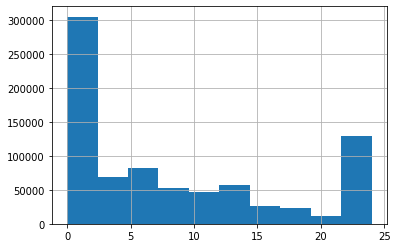

In [400]:
ticket_new_gen_dur.t_duration_hr.hist()